In [1]:
import numpy as np
import seaborn as sb
import json
import pandas as pd
import nltk
from nltk.tokenize import TreebankWordTokenizer,sent_tokenize
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import re, pickle
import contractions as con
from string import punctuation
from collections import Counter

tk = TreebankWordTokenizer()

In [2]:
# load datasets

twitter = pd.read_csv('/home/bibek/notebooks/tweet_16.csv',encoding='latin-1')
twitter = twitter[twitter.columns[-1]]

reddit = pd.read_csv('/home/bibek/Downloads/reddit.csv',encoding='latin-1').full_text
imdb_reviews = pd.read_csv('IMDB Dataset.csv').review
movie_plots = pd.read_csv('wiki_movie_plots_deduped.csv',encoding='latin-1').Plot

In [3]:
# consolidate data

text = []

text.extend(twitter)
text.extend(reddit)
text.extend(movie_plots)
text.extend(imdb_reviews)

len(text)

1748912

In [4]:
def preprocess_text(x):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;',' and ').replace('<br />','').replace('&quot;','').replace('&lt;','')
    x = x.lower()
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x).split()
    for i,w in enumerate(x):
        if '@' in w:
            x[i] = 'USER'
    x = ' '.join(x)
    punct_to_keep = """!,.:#?"-;/%$'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    return x



In [5]:
np.random.shuffle(text)

In [6]:
# sample cleaned text

idx = np.random.randint(0,len(text) - 1,10)

for i in idx:
    print(text[i])
    print()
    print(preprocess_text(text[i]))
    print('-----------------------------------------------')

says off to EGI  basag friends, here i come (headspin) http://plurk.com/p/111hyl

says off to egi basag friends , here i come headspin LINK
-----------------------------------------------
i wish people would @reply me  i need conversation

i wish people would USER me i need conversation
-----------------------------------------------
@Custardcuppcake ony the insistance of following &quot;nicole&quot; because she is sooo cool 

USER ony the insistance of following nicole because she is sooo cool
-----------------------------------------------
hanging out in raykas house cause she's too scared to be alone  gotta love the bestfraaannn

hanging out in raykas house cause she 's too scared to be alone gotta love the bestfraaannn
-----------------------------------------------
@carolynaaa28 btw that man i told you about yesterday, he finally died yesterday morning 

USER btw that man i told you about yesterday , he finally died yesterday morning
-----------------------------------------------

In [7]:
# clean text

clean_text = [preprocess_text(x) for x in tqdm(text)]

  0%|          | 0/1748912 [00:00<?, ?it/s]

In [8]:
minlen = 20
maxlen = 50

In [9]:
# import pretrained custom tokenizer

from bpe_tokenizer import BPETokenizer

if __name__ == "__main__":

    with open('tokenizer.pkl','rb') as f:
        tokenizer = pickle.load(f)
        

In [10]:
# split long text into smaller chunks

def split_long_text(text,minlen=100,maxlen=200):
    sents = sent_tokenize(text)
    tmp = []
    sent = ''
    for s in sents:
        if len((s + sent).split()) <= maxlen:
            if s.split()[-1] not in punctuation:
                sent = sent + s + '.'
            else:
                sent = sent + s
            sent = sent.strip()
            sent = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', sent)
            re.sub(r'\s+', ' ', sent)
        else:
            sent = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', sent)
            tmp.append(sent)
            sent = s
    
    sent = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', sent)
    sent = re.sub(r'\s+', ' ', sent)
    tmp.append(sent)
    
    return tmp
    


text_data = []

for text in tqdm(clean_text):
    if len(text.split()) >= minlen:
        splitted_text = split_long_text(text,minlen=minlen,maxlen=maxlen)
        text_data.extend(splitted_text)

  0%|          | 0/1748912 [00:00<?, ?it/s]

In [11]:
print('Number of sequences :',len(text_data))

Number of sequences : 1293431


In [12]:
# tokenize sequences

token_seq = []

for seq in tqdm(text_data):
    seq = seq.strip()
    seq = '<cls> ' + seq + ' <sep>'
    seq = tokenizer.tokenize(seq)
    token_seq.append(seq)

maxlen = max([len(x) for x in token_seq])
minlen = min([len(x) for x in token_seq])
maxlen,minlen

  0%|          | 0/1293431 [00:00<?, ?it/s]

(492, 2)

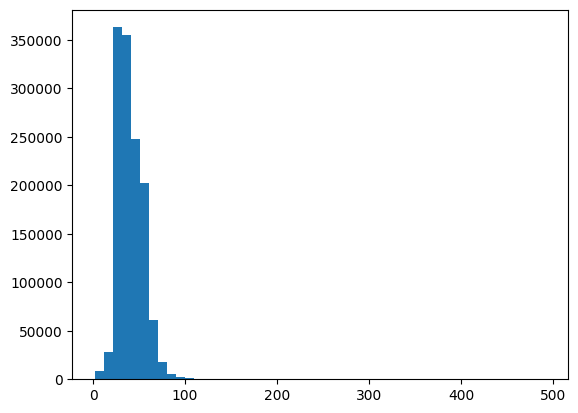

In [13]:
# visualize token count in sequences

plt.hist([len(x) for x in token_seq],bins=50)
plt.show()

In [14]:
# only keeping sequences with minimum 20 and maximum 60 tokens

token_seq = [x for x in token_seq if 20 <= len(x) <= 60]
len(token_seq)

1175934

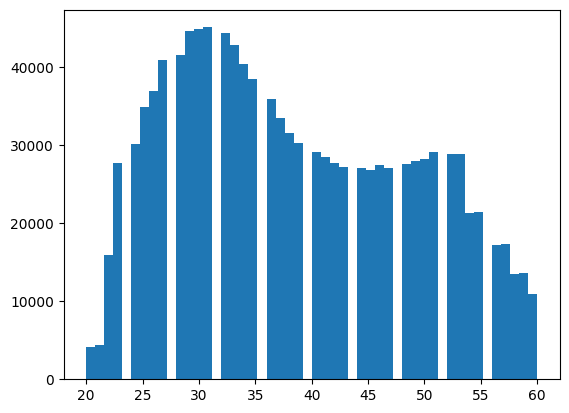

In [15]:
plt.hist([len(x) for x in token_seq],bins=50)
plt.show()

In [16]:
# sample subword-split

idx = np.random.randint(0,len(clean_text),10)


for i in idx:
    seq = clean_text[i].split()
    seq = ' '.join([tokenizer._split_oov(x) for x in seq])
    print(clean_text[i])
    print('-------------------------------------------------------')
    print(seq)
    print('=========================================================')

USER happy mother 's day to you vanda
-------------------------------------------------------
USER happy mother 's day to you van ## da
i almost forgot what it felt like to be happy . and i thank him for remimding me . and momma too
-------------------------------------------------------
i almost forgot what it felt like to be happy . and i thank him for re ## mi ## m ## ding me . and momma too
seems like os 10 . 5 . 7 corrupted the sleepimage file on my imac g5 : LINK
-------------------------------------------------------
seems like os 10 . 5 . 7 corrupted the sleep ## image file on my ima ## c g ## 5 : LINK
help ! i signed up for daily twittascope and i can't unsubscribe ! anyone know how i can do this ?
-------------------------------------------------------
help ! i signed up for daily twit ## ta ## scope and i can't un ## subs ## crib ## e ! anyone know how i can do this ?
i wish for the whole truth everytime you speak . maths
-----------------------------------------------------

In [17]:
# pad token sequences

token_seq = np.asarray([tokenizer.add_padding(seq,maxlen=60) for seq in token_seq])

In [18]:
token_seq.shape

(1175934, 60)

In [19]:
def get_dont_mask_tokens(vocab):
    tokens = list(dict(sorted(vocab.tokens.items(), key=lambda x: x[1], reverse=True)))[:10]
    tokens = tokens
    tokens = [vocab.w2i[t] for t in tokens] + [2,0,4,5]
    return np.asarray(tokens,np.int32)

dont_mask_tokens = get_dont_mask_tokens(tokenizer)
', '.join([tokenizer.i2w[t] for t in dont_mask_tokens])

'the, ., ,, to, and, a, of, is, in, that, <sep>, <pad>, <cls>, ##'

In [20]:
def create_masked_data(sequence,vocab_size,for_train=True,dont_mask_toks=np.asarray([2,0,4,5],np.int32)):
    
    seq = np.asarray(sequence,dtype=np.int32)
    
    # mask 12% of tokens
    end = np.where(seq == 2)[0][0]
    masked_seq = seq.copy()
    n_mask = int(len(np.where(seq>0)[0])*0.12)
    mask = ~np.isin(seq, dont_mask_toks)
    to_mask_idx = np.where(mask)[0]
    to_mask_prob = n_mask/len(to_mask_idx)
    probs = np.linspace(0,1,len(to_mask_idx))
    np.random.shuffle(probs)
    to_mask = masked_seq[to_mask_idx].copy()
    to_mask = np.where(probs>=to_mask_prob,to_mask,1)
    masked_seq[to_mask_idx] = to_mask
    masked_idx = np.where(masked_seq == 1)[0]
    
    # replace 1% of tokens with random tokens (only for training data) 
    if for_train:
        non_masked_idx = np.where(masked_seq > 5)[0]
        num_tok_to_replace = int((len(seq) - 2) * 0.015)
        rand_idx = non_masked_idx[np.random.randint(0,len(non_masked_idx)-1,num_tok_to_replace)]
        rand_replacements = np.random.randint(6,vocab_size,num_tok_to_replace)
        masked_seq[rand_idx] = rand_replacements
        
    return seq,masked_seq

i = np.random.randint(0,len(token_seq))
create_masked_data(token_seq[i],len(tokenizer.i2w),for_train=True)

(array([    4,    14, 19948,    73,  2755,   100,   135,    77,  1093,
          392,  5656, 19947,     8,    96,    65,  1922, 19946,   112,
           66,    19,     6,  1125,    11,    96,   161,  8463,    12,
            3,     9,  4120,  5974,    19,   955,  1543,   100,   119,
           10,     6,   542, 15878,  2334,     5,  7036,   596,    49,
           46,     6,    66, 19951,     2,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0], dtype=int32),
 array([    4,    14, 19948,    73,  2755,   100,   135,    77,  1093,
          392,  5656, 19947,     8,    96,    65,  1922,     1,   112,
           66,    19,     6,  1125,    11,    96,   161,  8463,    12,
            3,     9,  4120,  5974,    19,   955,     1,     1,   119,
           10,     6,     1, 15878,  2334,     5,     1,   596,    49,
            1,     6,    66, 19951,     2,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0], dtype=int32))

In [21]:
seq,masked = create_masked_data(token_seq[i],len(tokenizer.i2w),for_train=True)

print(' '.join([tokenizer.i2w[t] for t in seq if t != 0]))
print()
print(' '.join([tokenizer.i2w[t] for t in masked if t != 0]))
print()
idx = np.where(masked == 1)[0]
print(' '.join([tokenizer.i2w[t] for t in seq[idx] if t != 0]))

<cls> it 's also easier than many other zero waste habits , and much more effective . your time for the planet is much better invested in <unk> a vegan recipe for dinner tonight than most of the stuff minimalist influence ## rs talk about all the time ! <sep>

<cls> it 's also easier than many other <mask> waste <mask> , and much more effective . your time for the <mask> is much better invested in <mask> a vegan recipe for dinner tonight than most of the stuff <mask> <mask> ## rs talk about all the time ! <sep>

zero habits planet <unk> minimalist influence


In [22]:
np.random.shuffle(token_seq)

In [23]:
# dictionary for storing train and val sets

pretraining_data = {'train':{'seq':[],'masked_seq':[]},
                    'valid':{'seq':[],'masked_seq':[]}}

In [24]:
# split train and val

train,valid = [],[]
size = len(tokenizer.i2w)
val_size = 100000

for i,seq in enumerate(tqdm(token_seq)):
    
    if i >= val_size:
        seq,masked_seq = create_masked_data(seq,size,for_train=True)
        if len(seq) > 0:
            train.append((seq,masked_seq))
        
    else:
        seq,masked_seq = create_masked_data(seq,size,for_train=False)
        if len(seq) > 0:
            valid.append((seq,masked_seq))
        

        

  0%|          | 0/1175934 [00:00<?, ?it/s]

In [25]:
np.random.shuffle(train)
np.random.shuffle(valid)   

len(train),len(valid)

(1075934, 100000)

In [26]:
# store train and val sets

for seq,masked in train:
    pretraining_data['train']['masked_seq'].append(masked)
    pretraining_data['train']['seq'].append(seq)
    
for seq,masked in valid:
    pretraining_data['valid']['masked_seq'].append(masked)
    pretraining_data['valid']['seq'].append(seq)

In [27]:
# data and tokenizer

with open('short-length pretraining data.pkl','wb') as f:
    pickle.dump(pretraining_data,f)
    
with open('tokenizer.pkl','wb') as f:
    pickle.dump(tokenizer,f)